### How much would you recommend scaling bikes back between November and April?

The dual line axis chart we created shows seasonal demand patterns overall, but not the operational ceiling we need to plan for. ***For scaling decisions, what matters is peak demand at busy hours***. So, what we need here is the peak load per month,not the daily or monthly average. We group our rides by month and hour of day to find the maximum hourly trips in each month. Then we can compare winter peaks as a percentage of summer peaks, and by applying a margin of 10-15%, we can answer the question of how much we could scale back while still covering demand safely.

In [5]:
import pandas as pd
from pathlib import Path

file_path = Path(r"C:/Users/magia/OneDrive/Desktop/NY_Citi_Bike/2.Data/Prepared Data/nyc_2022_essential_data.csv")

hourly_counts = {}

for chunk in pd.read_csv(
    file_path,
    usecols=["started_at"],
    chunksize=500_000,          # adjust up/down depending on your RAM
    dtype=str,                  # avoid heavy date parsing while reading
    on_bad_lines="skip",        # skip any malformed rows
    low_memory=True,
    encoding_errors="ignore"
):
    s = pd.to_datetime(chunk["started_at"], errors="coerce")
    s = s[(s >= "2022-01-01") & (s < "2023-01-01")]
    s_hour = s.dt.floor("H").dropna()

    vc = s_hour.value_counts()
    for ts, cnt in vc.items():
        hourly_counts[ts] = hourly_counts.get(ts, 0) + int(cnt)

hourly = pd.Series(hourly_counts, dtype="int64").sort_index()
print("hours:", len(hourly), "| range:", hourly.index.min(), "→", hourly.index.max())

hours: 8759 | range: 2022-01-01 00:00:00 → 2022-12-31 23:00:00


In [8]:
# 'find monthly peak-hour demand

import pandas as pd

hourly_df = hourly.rename("trips").to_frame()
hourly_df["month"] = hourly_df.index.to_period("M")

# Find the hour with the max trips in each month
peak_idx = hourly_df.groupby("month")["trips"].idxmax()
peaks = hourly_df.loc[peak_idx].copy()

# Tidy up
peaks = peaks.reset_index().rename(columns={"index": "peak_hour"})
peaks["month"] = peaks["month"].astype(str)

# Use September as the baseline
if (peaks["month"] == "2022-09").any():
    july_peak = int(peaks.loc[peaks["month"] == "2022-09", "trips"].iloc[0])
else:
    july_peak = int(peaks["trips"].max())

peaks["%_of_september_peak"] = (peaks["trips"] / july_peak * 100).round(1)

# Show results
print(peaks[["month", "peak_hour", "trips", "%_of_september_peak"]]
      .sort_values("month")
      .to_string(index=False))

  month           peak_hour  trips  %_of_september_peak
2022-01 2022-01-19 17:00:00   5134                 37.4
2022-02 2022-02-23 17:00:00   7687                 55.9
2022-03 2022-03-18 17:00:00   9981                 72.6
2022-04 2022-04-12 17:00:00  11985                 87.2
2022-05 2022-05-17 18:00:00  12366                 90.0
2022-06 2022-06-14 18:00:00  12790                 93.1
2022-07 2022-07-26 18:00:00  12623                 91.8
2022-08 2022-08-24 18:00:00  12676                 92.2
2022-09 2022-09-08 18:00:00  13745                100.0
2022-10 2022-10-06 17:00:00  12701                 92.4
2022-11 2022-11-02 17:00:00  12128                 88.2
2022-12 2022-12-08 08:00:00   7761                 56.5


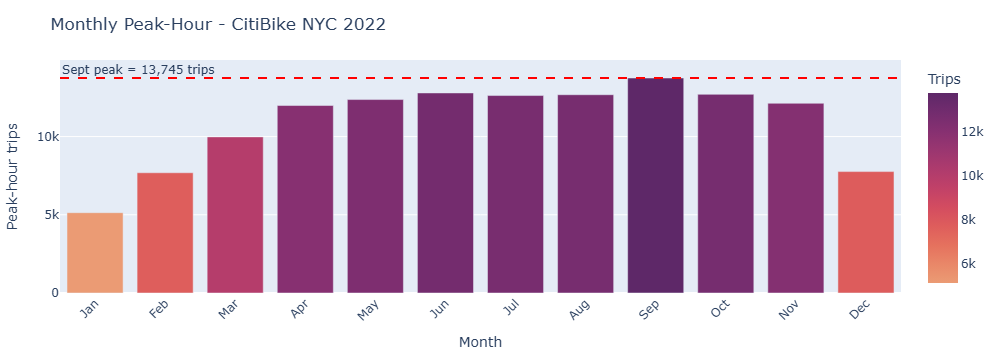

In [16]:
import plotly.express as px
import numpy as np

# --- Prep data ---
# Ensure chronological months and friendly month labels on X (no fake '1st' date)
peaks = peaks.sort_values("month").copy()
peaks["month_label"] = pd.to_datetime(peaks["month"].astype(str) + "-01").dt.strftime("%b")

# September peak (for baseline line in *trips*, not %)
sept_trips = int(peaks.loc[peaks["month"] == "2022-09", "trips"].iloc[0])

# String version of the actual peak hour for clean hover text
peaks["peak_hour_str"] = pd.to_datetime(peaks["peak_hour"]).dt.strftime("%Y-%m-%d %H:%M")

# --- Exact Flare colorscale from seaborn ---
palette = sns.color_palette("flare", 11)  # smooth warm scale
def rgb_tuple_to_str(t):
    r, g, b = (int(round(255*x)) for x in t)
    return f"rgb({r},{g},{b})"
colorscale = [[i/(len(palette)-1), rgb_tuple_to_str(c)] for i, c in enumerate(palette)]

# --- Plotly interactive bar chart (color by trips) ---
fig = px.bar(
    peaks,
    x="month_label",
    y="trips",
    color="trips",
    color_continuous_scale=colorscale,
    labels={"month_label": "Month", "trips": "Peak-hour trips"},
)

# % of September peak for hover
peaks["pct_of_sept"] = (peaks["trips"] / sept_trips * 100).round(1)

fig.update_traces(
    hovertemplate=(
        "<b>%{x} 2022</b>"
        "<br>Peak hour: %{customdata[0]}"
        "<br>Peak-hour trips: %{y:,}"
        "<br>% of Sept peak: %{customdata[1]:.1f}%<extra></extra>"
    ),
    customdata=np.c_[peaks["peak_hour_str"], peaks["pct_of_sept"]],
)

# Baseline at September's peak (in trips)
fig.add_hline(
    y=sept_trips,
    line_dash="dash",
    line_color="red",
    annotation_text=f"Sept peak = {sept_trips:,} trips",
    annotation_position="top left"
)

# Tidy layout
fig.update_layout(
    title="Monthly Peak-Hour - CitiBike NYC 2022",
    xaxis_title="Month",
    yaxis_title="Peak-hour trips",
    xaxis_tickangle=-45,
    margin=dict(l=40, r=20, t=60, b=60),
    coloraxis_colorbar_title="Trips"
)

fig.write_html(r"C:\Users\magia\OneDrive\Desktop\NY_Citi_Bike\4.Visualizations\monthly_peak_hour_demand.html", include_plotlyjs="cdn")

fig.show()

Our analysis gives us these results:

- Nov: Still strong peaks (~88%), so no meaningful scale-back until December.
- Dec: Sharp drop (~55%) → clear opportunity to scale down fleet ~30–40%.
- Jan: Peak demand drops to less than 40% of September → fleet can be scaled back by about half.
- Feb: Demand grows to ~55%, so getting it back to ~70% is recommended
- Mar: Growth continues with demand over 70%, so fleet at 80-85% should be fine
- Apr: At almost 90%, demand reaches peak heights, so full fleet capacity is needed hereafter.

Overall: A month-by-month approach is more practical than a blanket seasonal strategy, since peak demand varies widely(from ~37% to ~72% of maximum, and that is excluding Novemeber and April). This supports targeted winter scaling rather than uniform reductions.